In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import requests
cases_request = requests.get('https://coronavirus-tracker-api.herokuapp.com/confirmed')
deaths_request = requests.get('https://coronavirus-tracker-api.herokuapp.com/deaths')
recovered_request = requests.get('https://coronavirus-tracker-api.herokuapp.com/recovered')
cases_json_data = cases_request.json()
deaths_json_data = deaths_request.json()
recovered_json_data = recovered_request.json()

In [3]:
def transform_data(json_data, number_field_name):
    """Function that transforms the full json-data into a list of small dict-objects. 
    
    Each object states for a single day in a single country.
    """
    complete_list = []
    for country_data in json_data['locations']:
        for history_date, number in country_data['history'].items():
            if history_date == 'latest':
                continue
            day_data = {'country': country_data['country'], 'date_text': history_date, number_field_name: number}
            complete_list.append(day_data)
    return complete_list

cases_list = transform_data(cases_json_data, 'number_of_cases')
deaths_list = transform_data(deaths_json_data, 'number_of_deaths')
recovered_list = transform_data(recovered_json_data, 'number_of_recovered')
cases_list[:5]

[{'country': 'Afghanistan', 'date_text': '1/22/20', 'number_of_cases': 0},
 {'country': 'Afghanistan', 'date_text': '1/23/20', 'number_of_cases': 0},
 {'country': 'Afghanistan', 'date_text': '1/24/20', 'number_of_cases': 0},
 {'country': 'Afghanistan', 'date_text': '1/25/20', 'number_of_cases': 0},
 {'country': 'Afghanistan', 'date_text': '1/26/20', 'number_of_cases': 0}]

In [4]:
import pandas as pd
cases_df = pd.DataFrame(cases_list)
deaths_df = pd.DataFrame(deaths_list)
recovered_df = pd.DataFrame(recovered_list)

complete_df = deaths_df.merge(cases_df, on=['country', 'date_text'])
complete_df = complete_df.merge(recovered_df, on=['country', 'date_text'])
complete_df.head()

,country,date_text,number_of_deaths,number_of_cases,number_of_recovered
0,Afghanistan,1/22/20,0,0,0
1,Afghanistan,1/23/20,0,0,0
2,Afghanistan,1/24/20,0,0,0
3,Afghanistan,1/25/20,0,0,0
4,Afghanistan,1/26/20,0,0,0


In [5]:
from datetime import date, timedelta, datetime
from matplotlib import pyplot as plt
from datetime import date, datetime

#Set a country and the date of the epidemic's start
country = 'Italy'
start_date = date(2020, 2, 10)

# Filter dataframe by country and dates
country_df = complete_df[complete_df['country'] == country]
country_df['date'] = country_df['date_text'].apply(lambda x: datetime.strptime(x, '%m/%d/%y').date())
country_df['days'] = country_df['date'].apply(lambda x: (x - start_date).days)
country_df = country_df[country_df['days'] >= 0]
country_df = country_df.sort_values(by='days')
country_df.head()

,country,date_text,number_of_deaths,number_of_cases,number_of_recovered,date,days
2644129,Italy,2/10/20,0,3,0,2020-02-10,0
2644130,Italy,2/11/20,0,3,0,2020-02-11,1
2644131,Italy,2/12/20,0,3,0,2020-02-12,2
2644132,Italy,2/13/20,0,3,0,2020-02-13,3
2644133,Italy,2/14/20,0,3,0,2020-02-14,4


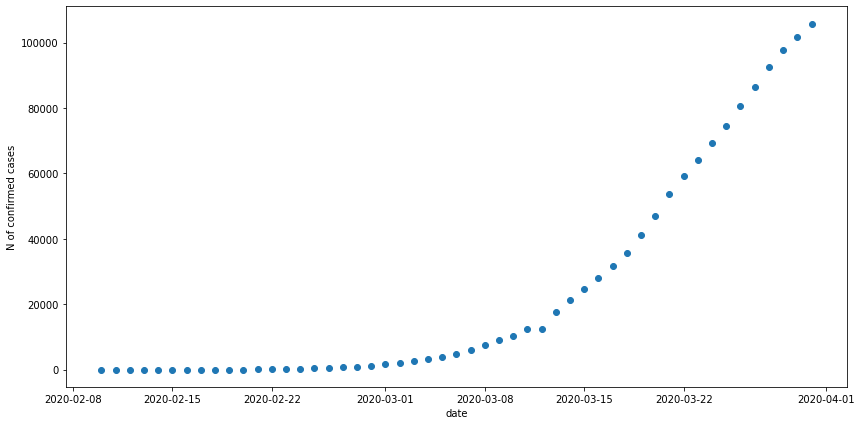

In [6]:
plt.figure(figsize=(14, 7))
plt.scatter(country_df['date'], country_df['number_of_cases'])
plt.xlabel('date')
plt.ylabel('N of confirmed cases')
plt.show()

In [7]:
from scipy.optimize import curve_fit
import numpy as np

def sigmoid(x, m, k, x0):
    """The standard logistic function."""
    return m / (1 + np.exp(-k * (x - x0)))

x_train = country_df['days'].to_numpy()
y_train = country_df['number_of_cases'].to_numpy()

params, __ = curve_fit(sigmoid, x_train, y_train)
params.tolist()

[129750.53521566899, 0.18535865143548613, 42.13568220173583]

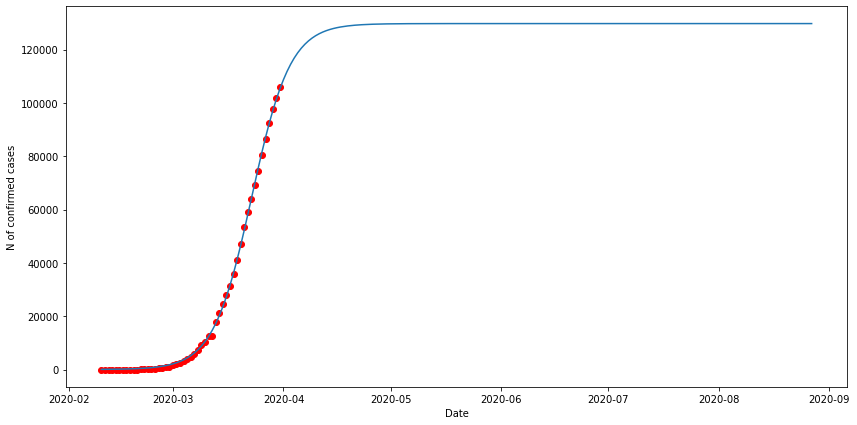

In [8]:
m, k, x0 = params.tolist()
days_to_predict = np.array(list(range(200)))
prediction_dates_list = [start_date + timedelta(days=i) for i in range(200)]
predicted_cases = sigmoid(days_to_predict, m, k, x0)
hictorical_dates = country_df['date']

plt.figure(figsize=(14,7))
plt.scatter(hictorical_dates, country_df['number_of_cases'], color='r')
plt.plot(prediction_dates_list, predicted_cases)
plt.xlabel('Date')
plt.ylabel('N of confirmed cases')
plt.show()

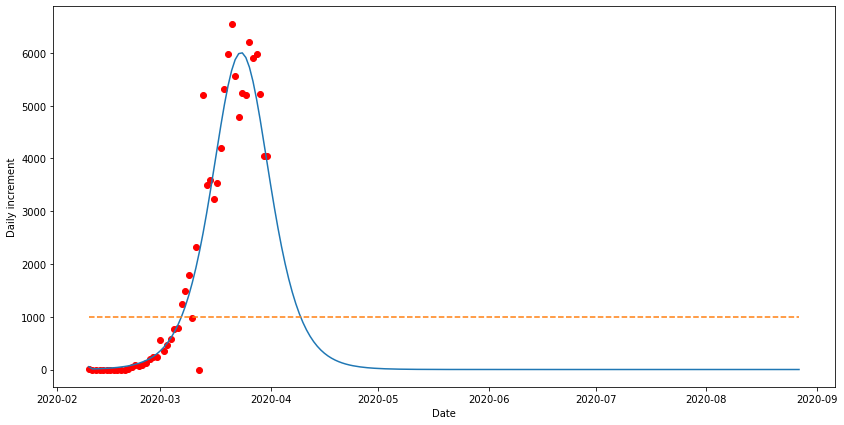

In [9]:
def get_new_daily_cases(cumulative_cases_list):
    """The function that transforms a list of accumulated daily cases to a list of new cases."""
    days_number = len(cumulative_cases_list)
    daily_cases = [cumulative_cases_list[i + 1] - cumulative_cases_list[i] for i in range(days_number - 1)]
    # Add the first day cases number as the first day increment
    daily_cases = [cumulative_cases_list[0]] + daily_cases
    return daily_cases

predicted_cases_list = predicted_cases.tolist()
predicted_daily_new_cases = get_new_daily_cases(predicted_cases_list)
historical_cases_list = y_train.tolist()
historical_daily_new_cases = get_new_daily_cases(historical_cases_list)

# Plot the real and predicted daily increments
plt.figure(figsize=(14,7))
plt.scatter(hictorical_dates, historical_daily_new_cases, color='r')
plt.plot(prediction_dates_list, predicted_daily_new_cases)
plt.plot(prediction_dates_list, [1000]*len(prediction_dates_list), '--')   # Trending line
plt.xlabel('Date')
plt.ylabel('Daily increment')
plt.show()

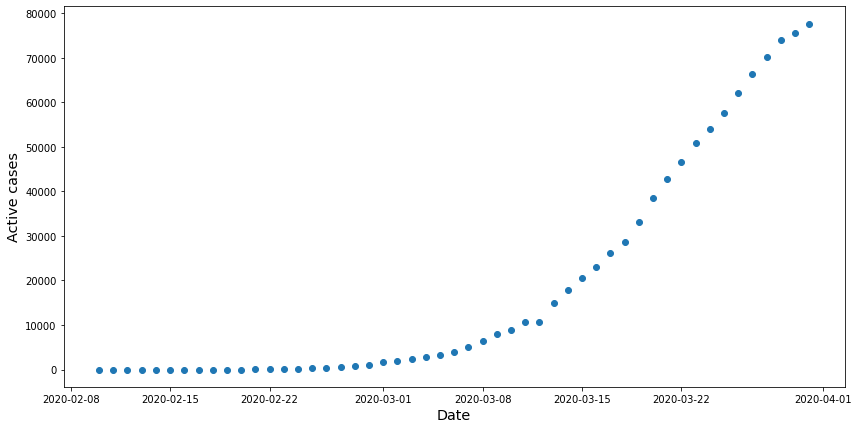

In [10]:
country_df['active_cases'] = (country_df['number_of_cases'] - 
                              country_df['number_of_deaths'] - country_df['number_of_recovered'])

plt.figure(figsize=(14,7))
plt.scatter(country_df['date'], country_df['active_cases'])
plt.xlabel('Date', fontsize='x-large')
plt.ylabel('Active cases', fontsize='x-large')
plt.show()

In [11]:
historical_deaths = country_df['number_of_deaths'].to_numpy()
historical_recoveries = country_df['number_of_recovered'].to_numpy()


def get_prob_vector(m, k, x0):
    """The function that returns the probability vector derived from the sigmoid function"""
    number_of_days = 90
    return [sigmoid(x, m, k, x0) for x in range(number_of_days)]

def predict_final_state(day, prob_vector, daily_cases=None):
    """Given a day number and the probability vector calculates the number of persons in the final state.
    
    It iterates through all previous days. For each previous day it takes the number of new confirmed cases.
    Then it calculates what fraction of this cohort changed their state to the final.
    If `daily_cases` is not specified the historical daily new cases are taken.
    """
    if daily_cases is None:
        daily_cases = historical_daily_new_cases
    accumulated_in_state = 0
    for previous_day in range(int(day) + 1):
        new_cases = daily_cases[previous_day]
        days_left = int(day) - previous_day
        if days_left > len(prob_vector) - 1:
            from_that_day = prob_vector[-1] * new_cases
        else:
            from_that_day = prob_vector[days_left] * new_cases
        accumulated_in_state += from_that_day
    return accumulated_in_state
    
def final_state_function(x, m, k, x0, daily_cases=None):
    """The function that given a set of days x and probability parameters 
    calculates the number of persons in the final state."""
    prob_vector = get_prob_vector(m, k, x0)
    return np.array([predict_final_state(day, prob_vector, daily_cases=daily_cases) for day in x])

In [12]:
from numpy import linalg as LA
from scipy.optimize import minimize

def objective_function(params):
    """The objective function that has to be minimized."""
    m_death, k_death, k_recovery, x0_death, x0_recovery = params
    deaths_forecast = final_state_function(x_train, m_death, k_death, x0_death)
    recoveries_forecast = final_state_function(x_train, 1 - m_death, k_recovery, x0_recovery)
    deaths_errors = historical_deaths - deaths_forecast
    recoveries_errors = historical_recoveries - recoveries_forecast
    return LA.norm(deaths_errors) + LA.norm(recoveries_errors)

bounds = [(0., 0.5), (0., None), (0., None), (0., None), (0., None)]
minimization_result = minimize(objective_function, [0.1, 1., 1., 1., 1.], bounds=bounds)
m_death, k_death, k_recovery, x0_death, x0_recovery = minimization_result.x    
m_death, k_death, k_recovery, x0_death, x0_recovery

(0.1509424424291656,
 0.5946042960578535,
 0.07863373520740886,
 4.031428225557039,
 31.438665048810595)

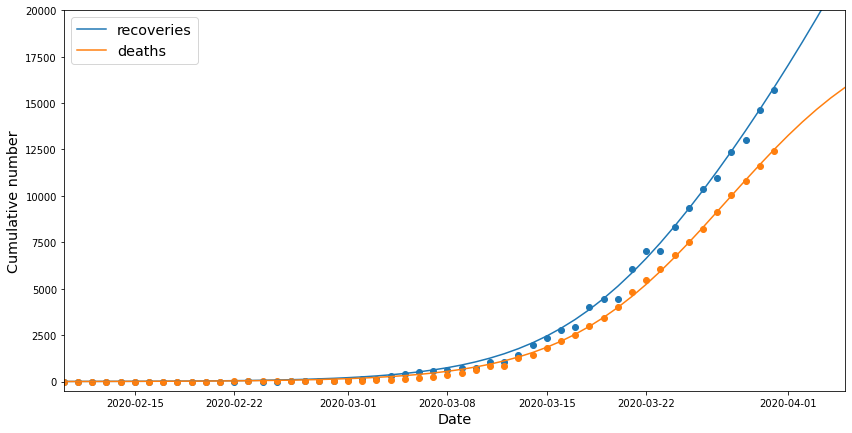

In [13]:
deaths_forecast = final_state_function(days_to_predict, m_death, k_death, x0_death, 
                                       predicted_daily_new_cases)
recoveries_forecast = final_state_function(days_to_predict, 1 - m_death, k_recovery, x0_recovery, 
                                           predicted_daily_new_cases)

plt.figure(figsize=(14,7))
plt.scatter(hictorical_dates, historical_recoveries)
plt.scatter(hictorical_dates, historical_deaths)

plt.plot(prediction_dates_list, recoveries_forecast, label='recoveries')
plt.plot(prediction_dates_list, deaths_forecast, label='deaths')
plt.legend(fontsize='x-large')
plt.xlim(date(2020, 2, 10), date(2020, 4, 5))
plt.ylim(-500, 20000)
plt.xlabel('Date', fontsize='x-large')
plt.ylabel('Cumulative number', fontsize='x-large')
plt.show()

In [14]:
int(np.max(deaths_forecast))

19584

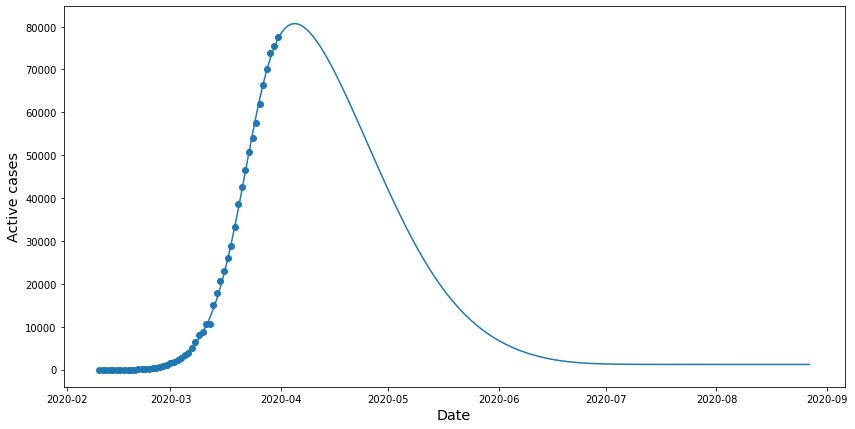

In [15]:
active_cases_forecast = np.array(predicted_cases_list) - deaths_forecast - recoveries_forecast
plt.figure(figsize=(14,7))
plt.plot(prediction_dates_list, active_cases_forecast)
plt.scatter(country_df['date'], country_df['active_cases'])
plt.xlabel('Date', fontsize='x-large')
plt.ylabel('Active cases', fontsize='x-large')
plt.show()

In [16]:
maximum_active_cases = max(active_cases_forecast)
date_index_for_maximum = active_cases_forecast.tolist().index(maximum_active_cases)
date_of_peak = prediction_dates_list[date_index_for_maximum]
date_of_peak

datetime.date(2020, 4, 5)